In [ ]:
import netCDF4 as nc
import glob
import datetime as dt
import pandas as pd
import numpy as np
import maths_tools.DateTimeTools as DTT
import maths_tools.FluxSiteTools as FST

from maths_tools import MetTools as MT

import matplotlib.pylab as plt

from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (10.,5)



In [2]:
IN_DIR='/data/grp/fluxdata/temp_extract_dir/'
OUT_DIR=IN_DIR+'converted/'

SITES = ['UKAMo','UKEBu','UKESa','UKGri','UKHam',\
         'UKHar','UKLBT','UKPL3','UKTad']

site_longnames = ['Authencorth Moss','Easter Bush','East Saltoun','Griffin','Alice Holt',\
                  'Harwood','London BT Tower','Pang Lambourne (Forest)','Tadham Moor']


In [3]:
TIME_NAME_IN='TIMESTAMP_START'
TIME_NAME_OUT='time'

VARNAMES_IN = ['SW_IN','NETRAD','PA','TA','H2O','P','WS','CO2',\
               'FC','SH','H',\
               'TS','TS_2','TS_3',\
               #'T_CANOPY','T_BOLE',\
               ]
VARNAMES_OUT= ['sw_down','rad_net','pstar','t','q_molmr','precip','wind','co2_atm',\
               'co2_flux','sensible_heat','latent_heat',\
               't_soil1','t_soil2','t_soil3',\
               #'t_canopy','t_bole',\
               ]



In [4]:
site='UKHam'
site_longname='Alice_Holt'
start_year=2005
end_year=2005
fill_value=-9999.

In [71]:
DATA_DICT = { varname:[] for varname in VARNAMES_OUT }
TIME = []
for year in range(start_year,end_year+1):
    print(year)
    infile=glob.glob(IN_DIR+'EFDC_L2_Flx_'+site+'_'+str(year)+'*.csv')[0]
    
    inlines=open(infile).readlines()
    
    headers=inlines.pop(0)
    headers=headers[:-1].split(',')
    #print(headers)
    
    for line in inlines:
        split=line[:-1].split(',')
        for invarname,outvarname in zip(VARNAMES_IN,VARNAMES_OUT):
            DATA_DICT[outvarname].append(split[headers.index(invarname)])
        TIME.append(split[headers.index(TIME_NAME_IN)])
        
    
  

2005


In [72]:
TIME =np.array([ dt.datetime( int(datestring[:4]),   \
                              int(datestring[4:6]),  \
                              int(datestring[6:8]),  \
                              int(datestring[8:10]), \
                              int(datestring[10:12])  )  \
                for datestring in TIME])
                     
TIME_secs=nc.date2num(TIME,units='seconds since '+str(TIME[0]))

In [73]:
print(TIME_secs)

[  0.00000000e+00   1.80000000e+03   3.60000000e+03 ...,   3.15306000e+07
   3.15324000e+07   3.15342000e+07]


In [74]:
for varname in VARNAMES_OUT:
    DATA_DICT[varname]=np.array([float(val) for val in DATA_DICT[varname]])
    DATA_DICT[varname]=np.ma.masked_equal(DATA_DICT[varname],fill_value)
    
    print(varname,DATA_DICT[varname].shape)

sw_down (17520,)
rad_net (17520,)
pstar (17520,)
t (17520,)
q_molmr (17520,)
precip (17520,)
wind (17520,)
co2_atm (17520,)
co2_flux (17520,)
sensible_heat (17520,)
latent_heat (17520,)
t_soil1 (17520,)
t_soil2 (17520,)
t_soil3 (17520,)


In [75]:
print(DATA_DICT['t'].mask)

[False False False ..., False False  True]


In [76]:
DF=pd.DataFrame(DATA_DICT,index=TIME)
DF['t_soil']=DF[['t_soil1','t_soil2','t_soil3']].mean(axis=1)
del DF['t_soil1']
del DF['t_soil2']
del DF['t_soil3']

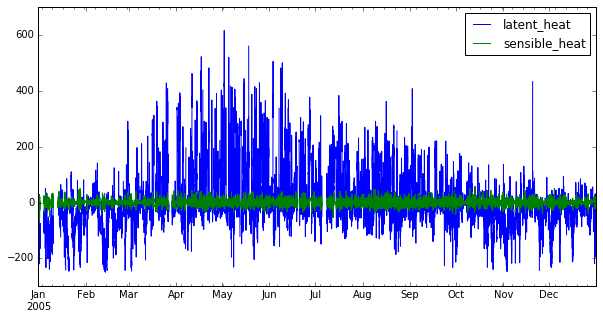

In [102]:
DF[['latent_heat','sensible_heat']].plot()

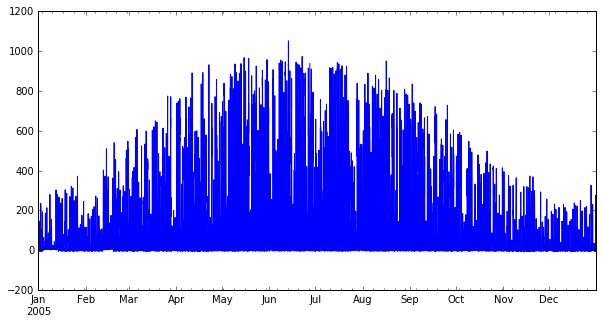

In [77]:
#DF[['t_canopy','t_bole']].plot()
#DF['co2_flux'].plot()
DF['sw_down'].plot()

In [78]:
GPP_data, TER_data, GPPFitParams = \
        FST.GPP_from_NEE_SW_T(DF['co2_flux'].values,DF['sw_down'].values,DF['t_soil'].values,\
                              spike_filter='median', FIT_maxfev=2000, \
                              ReturnResp=True, \
                              ReturnFitParams=True )



1e+20


In [79]:
DF['gpp']=GPP_data
DF['ter']=TER_data

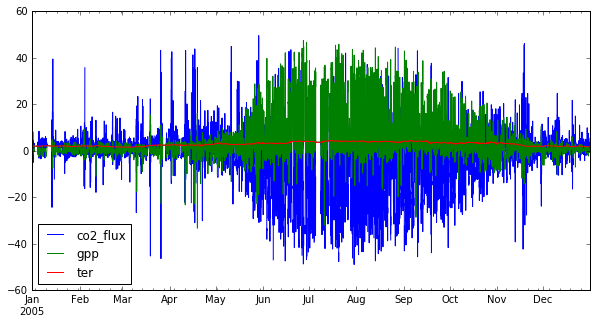

In [80]:
DF[ ['co2_flux','gpp','ter'] ].plot()

In [81]:

OUT_DATA_DICT={}

In [82]:
# No Pressure data so fill with 101.3 kPa
OUT_DATA_DICT['pstar']={ 'data':np.zeros_like(DATA_DICT['pstar'].data)+101300, \
                         'units':'Pa' }


(901,)


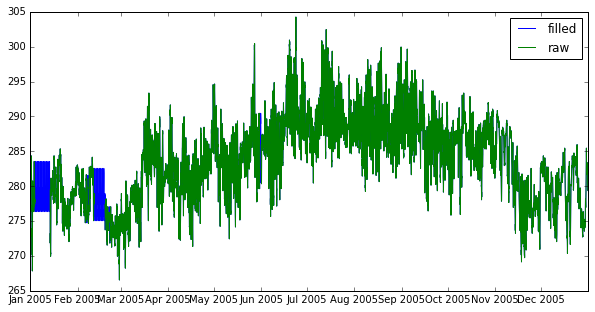

In [83]:
# Temperature
# Convert t to K
var='t'
temp_data=DATA_DICT[var].copy()+273.15
badex=np.where(temp_data.mask==True)[0]
print(badex.shape)
while len(badex)>0:
    temp_data[badex]=temp_data[badex-48]
    badex=np.where(temp_data.mask==True)[0]

OUT_DATA_DICT[var]={'data':temp_data.copy(),'units':'K'}

plt.plot(TIME,temp_data,label='filled')
plt.plot(TIME,DATA_DICT[var]+273.15,label='raw')
plt.legend()
plt.show()
        

In [84]:
#plt.plot(TIME[:300],temp_data[:300])
#plt.plot(TIME[:300],DATA_DICT['t'][:300])

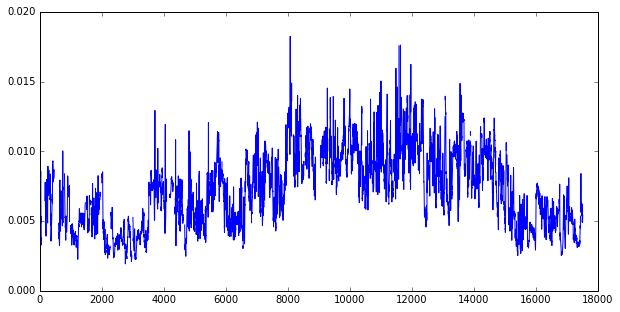

In [85]:
plt.plot(DATA_DICT['q_molmr']*18e-3/29)

/users/eow/edwcom/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


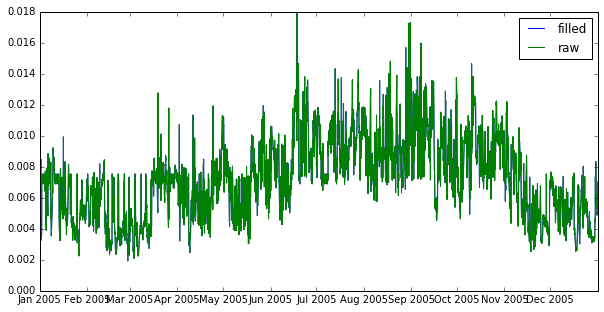

In [86]:
# fill RH with mean diurnal cycle values
for var in ['q_molmr']:
    temp_data=DATA_DICT[var].reshape(365,48)
    diurnal_cycle = temp_data.mean(axis=0)#

    for ihh in range(48):
        temp_data_hh=temp_data[:,ihh]
        temp_data_hh[temp_data_hh.mask==True]=diurnal_cycle[ihh]
        temp_data[:,ihh]=temp_data_hh
    
    # Convert to Specific Humidity
    spec_hum=MT.mixr2sh(temp_data.flatten()*18e-3/29)
    
    OUT_DATA_DICT['q']={'data':spec_hum,'units':'kg kg^-1'}
    
    #print(diurnal_cycle.shape)
    plt.plot(TIME,spec_hum,label='filled')
    plt.plot(TIME,MT.mixr2sh(DATA_DICT[var]*18e-3/29),label='raw')
    plt.legend()
    plt.show()
    
    #Out_DataDict[var]=temp_RH.flatten()

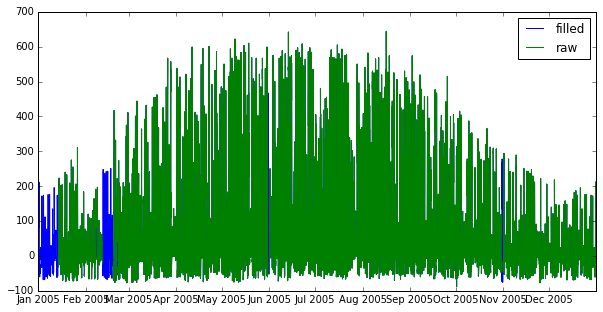

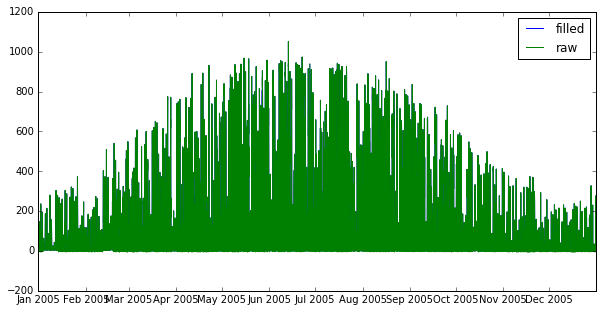

In [87]:
# Radiation Fields
for var in ['rad_net','sw_down']:
    temp_data=DATA_DICT[var].copy()
    badex=np.where(temp_data.mask==True)[0]
    # First fill with mirror of year
    temp_data[badex]=temp_data[-10-badex]
    badex=np.where(temp_data.mask==True)[0]
    #print(len(badex))
    # then fill with previous day value
    while len(badex)>0:
        temp_data[badex]=temp_data[0-48]
        badex=np.where(temp_data.mask==True)[0]
    
    if var=='sw_down':
        temp_data[temp_data<0]=0.0
        
    OUT_DATA_DICT[var]={'data':temp_data.copy(),'units':'W m^-2'}
    
    plt.plot(TIME,temp_data,label='filled')
    plt.plot(TIME,DATA_DICT[var],label='raw')
    plt.legend()
    plt.show()
        

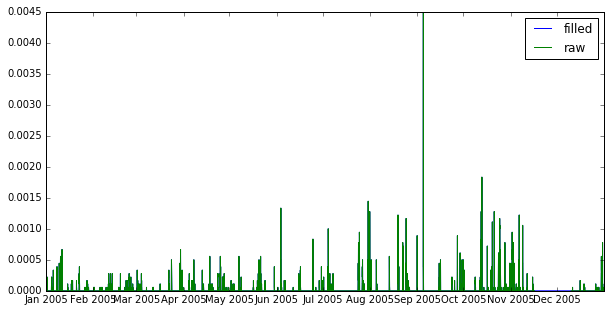

In [88]:
# Fill precip with zeros
var='precip'

temp_data=DATA_DICT[var].copy()/1800.
temp_data[temp_data.mask==True]=0

plt.plot(TIME,temp_data,label='filled')
plt.plot(TIME,DATA_DICT[var]/1800.,label='raw')
plt.legend()

OUT_DATA_DICT[var]={'data':temp_data,'units':'kg m^-2 s^-1'}

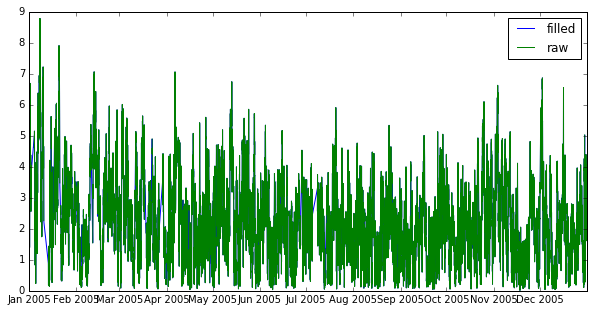

In [89]:
var='wind'
temp_data=DATA_DICT[var].copy()
badex=np.where(temp_data.mask==True)[0]
goodex=np.where(temp_data.mask==False)[0]
filled_data=np.interp(TIME_secs,TIME_secs[goodex],temp_data[goodex])
OUT_DATA_DICT[var]={'data':filled_data,'units':'m s^-1'}

plt.plot(TIME,filled_data,label='filled')
plt.plot(TIME,DATA_DICT['wind'],label='raw')
plt.legend()


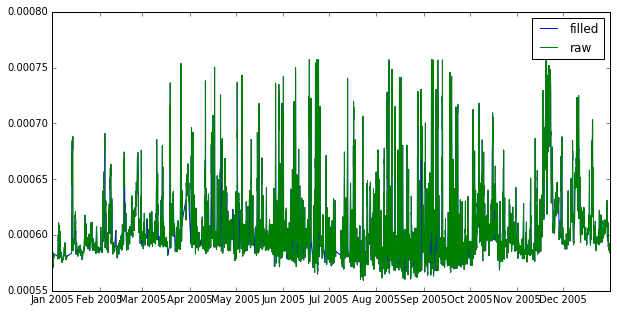

In [97]:
#plt.plot(TIME[10000:10400],DATA_DICT['co2'][10000:10400])
#plt.show()
#plt.plot(TIME[10000:10400],DATA_DICT['co2'][10000:10400]*(44e-6/29)*1e4)
#plt.show()
var='co2_atm'
temp_data=DATA_DICT[var].copy()*(44e-6/29)
badex=np.where(temp_data.mask==True)[0]
goodex=np.where(temp_data.mask==False)[0]
filled_data=np.interp(TIME_secs,TIME_secs[goodex],temp_data[goodex])
OUT_DATA_DICT[var]={'data':filled_data,'units':'kg kg^-1'}

plt.plot(TIME,filled_data,label='filled')
plt.plot(TIME,DATA_DICT[var]*(44e-6/29),label='raw')
plt.legend()


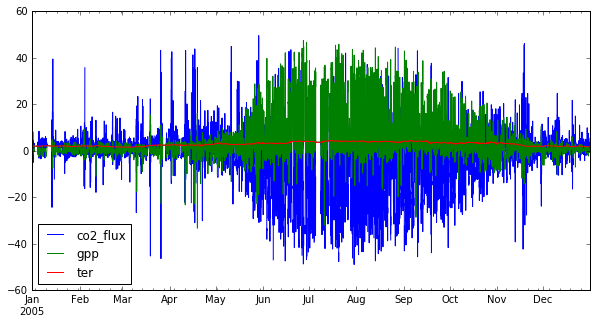

In [98]:
DF[ ['co2_flux','gpp','ter'] ].plot()

In [104]:
vars=['co2_flux','gpp','ter']
for var in vars:
    OUT_DATA_DICT[var]={'data':DF[var].values,'units':'molC m^-2 s^-1'}

vars=['sensible_heat','latent_heat'] 
for var in vars:
    OUT_DATA_DICT[var]={'data':DF[var].values,'units':'W m^-2'}



In [105]:
print('IN:')
for var in DATA_DICT:
    print(var)

print('\nOUT:')
for var in OUT_DATA_DICT:
    print(var,OUT_DATA_DICT[var]['units'])

IN:
latent_heat
t_soil1
co2_atm
wind
sensible_heat
pstar
co2_flux
rad_net
t_soil2
precip
t
t_soil3
q_molmr
sw_down

OUT:
latent_heat W m^-2
co2_atm kg kg^-1
gpp molC m^-2 s^-1
wind m s^-1
sensible_heat W m^-2
pstar Pa
co2_flux molC m^-2 s^-1
rad_net W m^-2
q kg kg^-1
precip kg m^-2 s^-1
t K
ter molC m^-2 s^-1
sw_down molC m^-2 s^-1


In [106]:
#Output data to netCDF
OUTFILE=OUT_DIR+site+'_'+str(start_year)+'_JULES_drivedata.nc'
outf=nc.Dataset(OUTFILE,'w')

outf.createDimension('time',len(TIME))
outf.createDimension('land',1)

outvar=outf.createVariable('time','float32',('time'))
outvar.units='seconds since '+str(TIME[0])
outvar[:]=TIME_secs

for var in OUT_DATA_DICT:
    outvar=outf.createVariable(var,'float32',('time','land'))
    outvar.units=OUT_DATA_DICT[var]['units']
    outvar[:]=OUT_DATA_DICT[var]['data']
    
outf.title='Gap filled met data for the Alice Holt flux tower'

outf.title='Non gap filled flux data for the Alice Holt flux tower'

outf.owner='Edward Comyn-Platt (edwcom@ceh.ac.uk)'

outf.close()

In [107]:
print(OUT_DIR)

/data/grp/fluxdata/temp_extract_dir/converted/
